# Part a
This notebook contains a step-by-step walkthrough of task a) using both code and text.

In [2]:
%load_ext autoreload
%autoreload 2
#Add own modules to path
import sys
sys.path.append('../..')
sys.path.append('../../src/')

### Loading the data and constructing the design matrix
In this part the terrain data used in previous project will be used again. 100x100 data points is extracted from the data and will be the default amount of data points.

For simplicity one function has been created and is used to load the data and create the design matrix. Degree 4 is choosen for the polynomial design matrix and will be used in further analyses.

In [3]:
from src.data.create_dataset import create_dataset
X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=8) 

### Splitting and plotting the data

/home/oliverif/courses/AppliedDataAnalysis/projects/FYS-STK4155-project2/notebooks/Reports/../../src/visualization/visualize.py:45: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Test data'}, xlabel='X', ylabel='Y'>

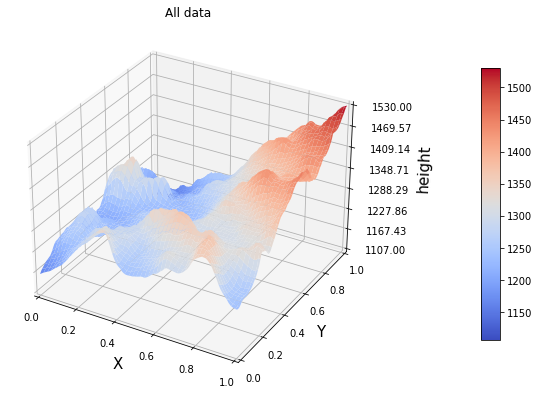

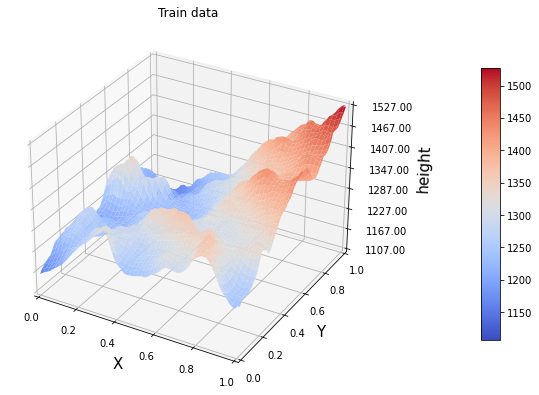

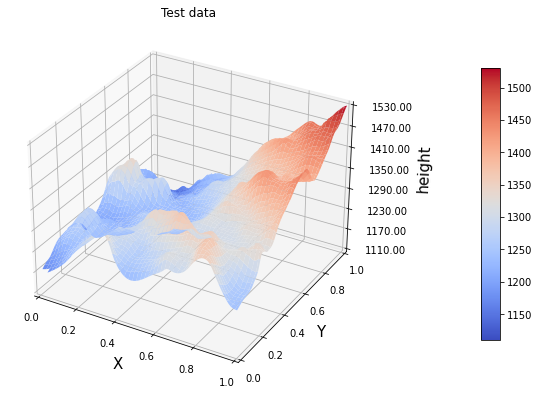

In [4]:
from src.visualization.visualize import plot_surf_from_X
from sklearn.model_selection import  train_test_split

X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

plot_surf_from_X(X,z,'All data')
plot_surf_from_X(X_train,z_train,'Train data')
plot_surf_from_X(X_test,z_test,'Test data')

Above plots shows z, z_train and z_test plotted on a 2 by 2 grid spanning 0 to 1. Cubic interpolation is used to fill in the blanks, but some are not possible to interpolate to because they lie outside the convex hull of the data, meaning there's no data point on the other side to use in interpolation.

As can be seen, they're not very easy to distinguish to the naked eye, but it is at least clear from the test data that some details are missing given it's smooth curves.

Anyhow, interpolation enables us to plot a smooth surface containing the predicted values of our future model.

### Scaling the data
The data is scaled using SKlearn's StandardScaler. Here standardization is used by subtracting the mean and dividing by std. The reason is that it helps the stochastic gradient descent algorithm converge faster, as it reduces the amount of steps needed to reach a good or optimal solution. This is because when standardizing there are less ravines(i.e mixture of steep and flat directions), which an sgd algorithm doesn't tend to handle very well. A steep hill will cause a big gradient that may in turn cause the sgd to overshoot at the next step. Standardizing ensures the parameter space is homogenous(i.e error ellipsis shown in image is more circular).

![standardization](../../figures/standardization_sgd.PNG)

(source: <i>Python Machine Learning - Second Edition</i>, by Sebastian Raschka & Vahid Mirjalili)

This is an argument for scaling the features, X and not the target data, z. However, as we will see later when fitting neural networks, high values of z can lead to initial errors being large which again may cause exploding gradients.
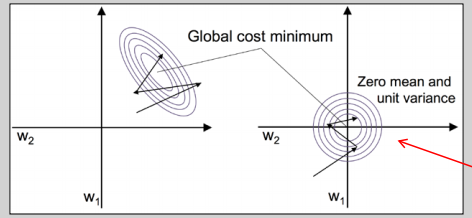

/home/oliverif/courses/AppliedDataAnalysis/projects/FYS-STK4155-project2/notebooks/Reports/../../src/visualization/visualize.py:45: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Scaled test data'}, xlabel='X', ylabel='Y'>

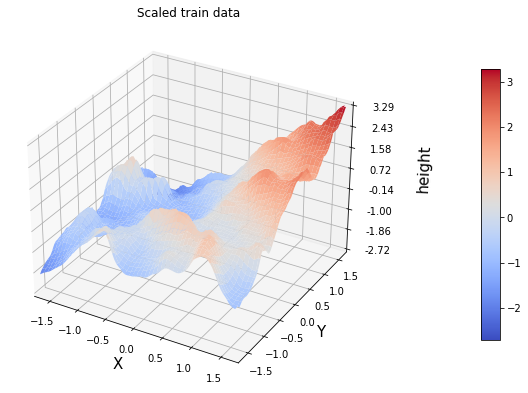

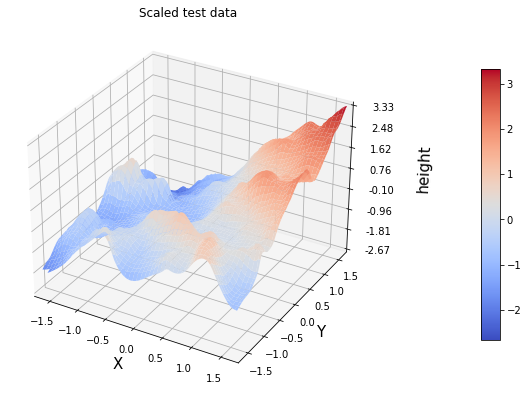

In [5]:
from sklearn.preprocessing import StandardScaler
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)

X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)
plot_surf_from_X(X_train,z_train,'Scaled train data')
plot_surf_from_X(X_test,z_test,'Scaled test data')

### Revisiting regular OLS and Ridge
OLS and Ridge using matrix inversion was studied in former project, but will be presented here to provide basis for comparison. As the squared erro cost function is convex, any local minima is the a global minima. As such, a solution using sgd will converge towards the analytical solution(i.e the optimal solution) with enough iterations and low enough learning rate.

In [6]:
from src.modelling.linreg import LinReg
import numpy as np
lmb = 0.1
ols =LinReg(regularization = None).fit(X_train,z_train)
ridge = LinReg(regularization = 'l2', lmb = lmb).fit(X_train,z_train)

print('OLS\t','\tRidge')
print(np.column_stack((ols.beta,ridge.beta)))

OLS	 	Ridge
[[ 0.00000000e+00  0.00000000e+00]
 [ 5.38207488e+00  2.57849571e+00]
 [ 3.57171913e+00  1.59146855e+00]
 [-1.57922673e+01 -5.52500791e+00]
 [-7.85163202e+01 -1.82900176e+00]
 [ 4.65439238e+01 -5.27389086e+00]
 [ 1.59668469e+02  2.93236142e+00]
 [ 9.30905013e+01  3.03120564e+00]
 [ 4.35299932e+02 -6.68553087e+00]
 [-4.61320122e+02  7.38519558e+00]
 [-8.96243642e+02  3.23420214e+00]
 [ 4.44827252e+02  1.46218684e+00]
 [-1.13286703e+03  3.67140786e+00]
 [-7.85666152e+02  1.90720657e+00]
 [ 1.40397220e+03  1.76656506e+00]
 [ 2.12784306e+03 -7.48037861e-02]
 [-1.05081618e+03 -2.86704864e+00]
 [ 6.15107992e+02  5.44647405e+00]
 [ 2.24369274e+03 -2.56355485e-01]
 [ 4.11796085e+02  3.34177472e+00]
 [-1.90613145e+03 -4.58077757e+00]
 [-2.44777097e+03 -2.59849413e+00]
 [ 6.25965860e+02 -3.81430571e+00]
 [ 7.66693110e+02  3.39561249e+00]
 [-1.86191806e+03 -3.69593322e+00]
 [-1.81204242e+03 -3.58284067e+00]
 [ 3.37219386e+02  3.23054425e+00]
 [ 1.11297417e+03 -4.24589228e+00]
 [ 1.362

The columns above show beta values for ols and ridge respectively. As can be seen, some of the higher parameters have been dampened with Ridge

OLS train[MSE,R2]: (0.0465227265512376, 0.9534772734487624) 
OLS test[MSE,R2]: (0.051288065415979786, 0.9479542957137231)
Ridge train[MSE,R2]: (0.0465227265512376, 0.9534772734487624) 
Ridge test[MSE,R2]: (0.051288065415979786, 0.9479542957137231)


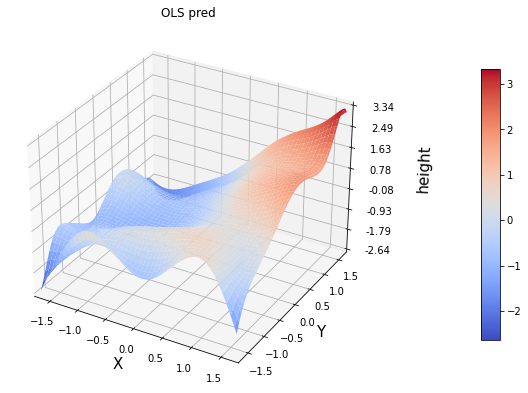

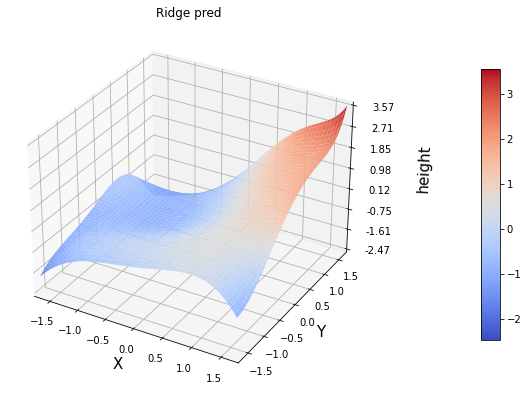

In [7]:
from src.model_evaluation.metrics import MSE_R2
#Predict test and train
z_tilde_ols = ols.predict(X_train)
z_pred_ols = ols.predict(X_test)
z_tilde_ridge = ridge.predict(X_train)
z_pred_ridge = ridge.predict(X_test)

#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols)

#Concatenating X_train and X_test so that we 
#can plot the whole predicted surface
X_ = np.concatenate((X_train,X_test))

plot_surf_from_X(X_,np.concatenate((z_tilde_ols,z_pred_ols)),'OLS pred')
plot_surf_from_X(X_,np.concatenate((z_tilde_ridge,z_pred_ridge)),'Ridge pred')

#Printing the scores
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

The scores indicate a relatively good fit. The MSE is low in both cases, the scale is also quite low, however we also see that the R2 score is quite close to 1, indicating a good fit. From the looks of it, the surfaces doesn't look very much like the original, but a lot smoother. If the goal is to recreate terrain for visual purposes we might require an even better score and a higher complexity model.

### Regression using stochastic gradient descent
In place of matrix inversion when fitting parameters, we will in this case use sgd optimization.
To begin with, some parameters are set rather arbitrarily. Batch_size is 64 as a multiplum of 2 often enables more efficient vectorized calculations. The number of epochs are set to 100, which is low but demonstrates how sgd needs certain amounts of epochs to converge. Learning rate is set to 0.01, and when using regularization, lmb is set to 0.1. For demonstration purposes, the polynomial degree of the design matrix is tuned back to 4 as it results in fewer beta values to print out.

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.981590,0.202433,2.427255,0.213699
2,1.723421,0.076981,1.360846,0.079421
3,-6.290071,0.774109,-4.556461,0.755095
4,-7.182376,-0.741338,-6.361064,-0.736197
5,-3.380185,0.029119,-2.363589,0.020591
6,6.940805,0.160371,4.974382,0.153146
7,9.336310,0.630669,8.326830,0.626429
8,2.644666,-0.204309,2.031220,-0.213440


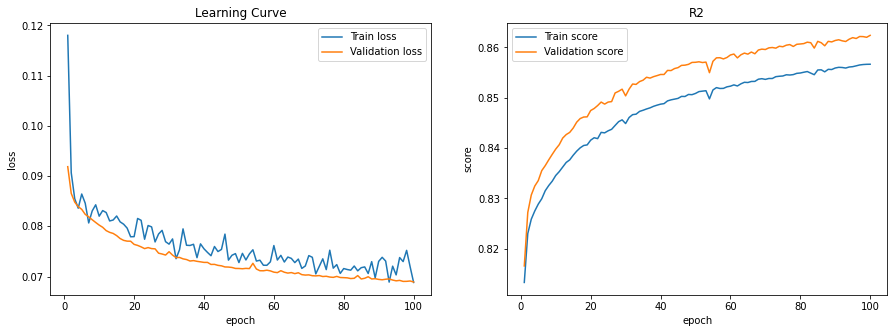

In [8]:
from src.modelling.linreg import SGD_linreg
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=4)
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2) 
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)

ols =LinReg(regularization = None).fit(X_train,z_train)
ridge = LinReg(regularization = 'l2', lmb = lmb).fit(X_train,z_train)

lmb = 0.1
batch_size = 64
n_epochs = 100
lr0 = 0.01
#initialize SGD linreg
sgd_ols = SGD_linreg(regularization = None, 
                     momentum= 0,
                     lr0=lr0,
                     batch_size = batch_size, 
                     n_epochs = n_epochs,
                     )
sgd_ridge = SGD_linreg(regularization = 'l2',lmb=0.001,
                       momentum= 0,
                       lr0=lr0,
                       batch_size = batch_size, 
                       n_epochs = n_epochs
                       )

#Fit sgd optimizer
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

It can be seen that the parameters resulting from the SGDs does have a way to go to reach the analytical solutions. Note that since the cost functions(both with and without regularization) are convex, the sgd should converge to the analytical solution with enough epochs and low enough learning rate. From the learning curve of OLS it can be observed that the curve is still decreasing at 100 epochs. Similarily, from the score plot it can be seen the score is still increasing when the training finished.

Increasing n_epochs drastically to 10 000

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.981590,2.138225,2.427255,1.859142
2,1.723421,1.141113,1.360846,0.986266
3,-6.290071,-3.347315,-4.556461,-2.735259
4,-7.182376,-6.256085,-6.361064,-5.577600
5,-3.380185,-1.518755,-2.363589,-1.263339
6,6.940805,3.355218,4.974382,2.847895
7,9.336310,8.201625,8.326830,7.381256
8,2.644666,1.856093,2.031220,1.445815


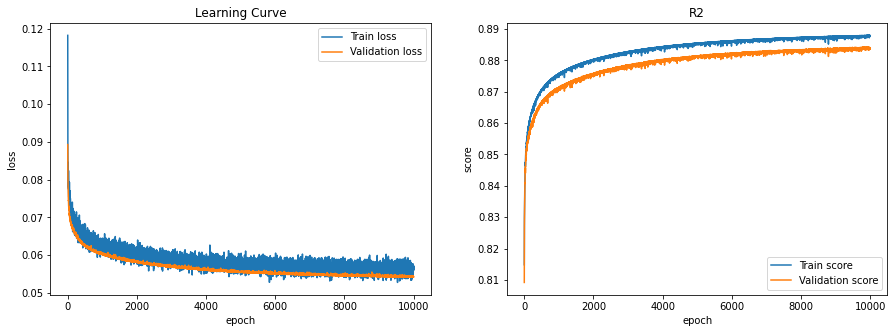

In [9]:
n_epochs = 10000

sgd_ols.set_params(n_epochs=n_epochs)
sgd_ridge.set_params(n_epochs=n_epochs)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

Loss and score are still somewhat improving upon termination, however much less. The parameters are still relatively different from the analytical ones. This may indicate that it doesn't take much to achieve score above 86%, but substantially harder to improve the latter 14%. Increasing the number of epochs may improve the results. Though, running this took about 4,5 minutes which doesn't exactly allow for quick prototyping. As a more complex design matrix and more data would lead to a lot longer running times, it's safe to say that the optimization method could benefit from running faster. 

#### Momentum
Momentum can be used to achieve faster convergence(i.e fewer epochs are needed for similar results). When using momentum during sgd optimization, we are in essence keeping track of a moving avergage and adding it on every sgd step. Moving average is often used to smooth noisy curves as consistent changes affect the average much more than noise. In the same way, using momentum allows the optimization to be less sensitive to sudden changes in the gradient. In other words, if a direction is consistently good to follow then sudden changes in the gradient will not affect the course very much. Unless of course, the change starts to become consitent.
The 'momentum' parameter specifies the amount of the moving average we're adding on each iteration. We are using momentum=0.5 which is a rather standard value.

In [10]:
n_epochs = 10000

sgd_ols.set_params(n_epochs = n_epochs, momentum=0.5)
sgd_ridge.set_params(n_epochs = n_epochs, momentum=0.5)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
df

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.981590,2.606664,2.427255,2.165139
2,1.723421,1.545457,1.360846,1.251714
3,-6.290071,-4.928546,-4.556461,-3.755365
4,-7.182376,-6.864528,-6.361064,-6.045621
5,-3.380185,-2.816155,-2.363589,-2.022002
6,6.940805,5.230394,4.974382,4.055799
7,9.336310,8.902777,8.326830,7.938164
8,2.644666,2.466969,2.031220,1.794266


As can be seen the parameters are getting even closer with the same amount of epochs.

#### Learning rate
Increasing the learning rate will make the sgd optimizer take a "bigger" step on each iteration and may in turn result in faster convergence. However, if the learning rate is too high, the optimization might overshoot and miss the target(being the optimal solution) and possibly diverge. A better learning rate would be one that decreases as the optimizer gets closer to the solution, allowing higher learning rates to begin with. This will be explored later.

In [11]:
lr0 = 0.1

sgd_ols.set_params(lr0 = lr0)
sgd_ridge.set_params(lr0 = lr0)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
df

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.981590,3.003770,2.427255,2.400547
2,1.723421,1.676428,1.360846,1.283820
3,-6.290071,-6.359574,-4.556461,-4.280253
4,-7.182376,-7.140684,-6.361064,-6.264434
5,-3.380185,-3.197741,-2.363589,-2.187416
6,6.940805,7.061756,4.974382,4.588894
7,9.336310,9.377082,8.326830,8.156153
8,2.644666,2.604944,2.031220,1.955589


By applying a decaying learning rate schedule, the learning rate will decrease with increasing epochs. This can possibly mitigate the flucutations around the solution that may happen with high constant learning rates.

In [12]:
lr0 = 0.1

sgd_ols.set_params(learning_shedule = 'decaying')
sgd_ridge.set_params(learning_shedule = 'decaying')

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
df

,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,2.981590,3.004139,2.427255,2.326911
2,1.723421,1.698391,1.360846,1.293160
3,-6.290071,-6.306948,-4.556461,-4.279926
4,-7.182376,-7.205321,-6.361064,-6.165764
5,-3.380185,-3.364604,-2.363589,-2.259591
6,6.940805,6.980091,4.974382,4.585268
7,9.336310,9.294223,8.326830,8.151097
8,2.644666,2.761503,2.031220,1.798611


As can be seen, the parameters are getting very close, and we're still using 4,5 minutes.
An 

In [13]:
from sklearn.linear_model import SGDRegressor
sgd_sk = SGDRegressor(fit_intercept = False, max_iter = 1000, penalty=None, eta0 = 0.01,tol=None)
sgd_sk.fit(X_train,z_train.ravel())

SGDRegressor(fit_intercept=False, penalty=None, tol=None)

In [14]:
sgd_sk.coef_.T

array([ 0.        ,  0.32684152,  0.16490935,  0.70612802, -2.14398151,
        0.23711434,  0.47048395,  2.53684512, -0.29448518,  0.34044588,
       -1.43658895,  0.66575246, -1.74218854,  2.0026607 , -1.0713344 ])